# Air quality comparison in Turin during 2020
Comparing Google mobility data with air quality data provided by regional autority (ARPA).

In [20]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import dates

## Mobility Dataset:

### Reading mobility data 
Provided by: <br>
Google LLC "Google COVID-19 Community Mobility Reports".
https://www.google.com/covid19/mobility/ 

In [21]:
path = 'data/Mobility/2020_IT_Region_Mobility_Report.csv'
palette = ["blue","red","green","orange","purple","brown"]
labels=['Retail & Recreation','Grocery & Pharmacy','Parks','Transit stations','Workplaces','Residential']
positions = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']

it_mobility_data = pd.read_csv(path, parse_dates=['date'])

### Filtering Data

In [22]:
#Filtering by sub_region
to_mobility_data = it_mobility_data[it_mobility_data['sub_region_2'] == 'Metropolitan City of Turin'].copy()
#remove empty column
to_mobility_data.dropna(how='all', axis=1, inplace=True)

### Multi-Line plot

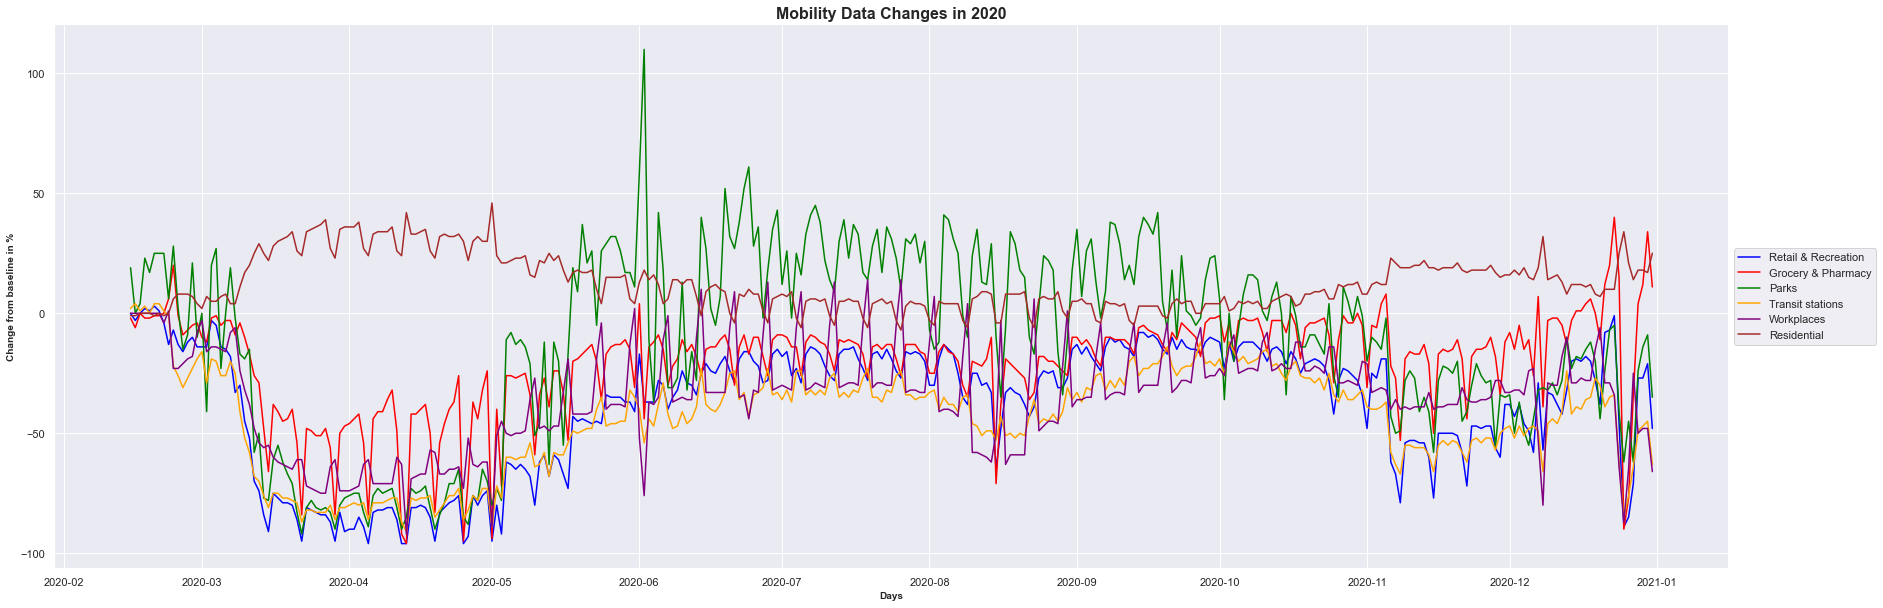

In [23]:
#set seaborn grapichs theme
sns.set_theme()

plt.figure(figsize=(30, 10))




# create a color palette
#palette = plt.get_cmap('Paired')

num = 0
plots =[]

for y in positions:
    line = to_mobility_data[y]
    p = plt.plot(to_mobility_data.date,line, label=labels[num], color=palette[num])
    plots += p
    num+=1

plt.xlabel('Days',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.ylabel('Change from baseline in %',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.legend(handles=plots)
plt.title("Mobility Data Changes in 2020",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
sns.despine()
plt.show()

#### Rename columns

In [24]:
to_mobility_data= to_mobility_data.rename(columns = {'retail_and_recreation_percent_change_from_baseline':labels[0], 'grocery_and_pharmacy_percent_change_from_baseline':labels[1],
                                    'parks_percent_change_from_baseline':labels[2],'transit_stations_percent_change_from_baseline':labels[3],
                                    'workplaces_percent_change_from_baseline':labels[4],'residential_percent_change_from_baseline':labels[5],})

## Air Quality Dataset:

### Reading ARPA data 
Provided by: <br>
Arpa Piemonte <br>
Dipartimento Rischi naturali e ambientali <br>
https://aria.ambiente.piemonte.it/

In [25]:
def read_ARPA_csv(path):
    dataFrame = pd.read_csv(path, sep=';',dtype={'Data rilevamento': str, 'Ora':str},index_col=False ) 

    #merge date and hours and parsing
    dataFrame["Data rilevamento"] = dataFrame["Data rilevamento"] + " " +  dataFrame["Ora"]
    dataFrame["Data rilevamento"] = pd.to_datetime(dataFrame["Data rilevamento"], format='%d/%m/%Y %H:%M') 
    return dataFrame

def get_daily_data(path,start_date):
    initial_data=read_ARPA_csv(path)
    #group by day
    data_daily = initial_data.resample('D', on='Data rilevamento').mean()
    data_daily = data_daily[(data_daily.index.get_level_values('Data rilevamento') >= start_date)]     
    data_daily.reset_index(inplace=True)

    return data_daily

def get_daily_adjusted_data(basePath):
  yearly_data = []

  #getting all the dataset
  for x in range(2012, 2020):
    data = get_daily_data(basePath +'_' + str(x) + '-01-01_' + str(x) + '-12-31.csv',str(x) + '-01-01 ')[['Data rilevamento','Valore']]
    #take only the day of the year
    data['Data rilevamento']= data['Data rilevamento'].dt.dayofyear
    yearly_data.append(data)

  #create daily baseline
  avg_daily_baseline=pd.concat([yearly_data[0],yearly_data[1],yearly_data[2],yearly_data[3],yearly_data[4],yearly_data[5],yearly_data[6],yearly_data[7]]).groupby('Data rilevamento', as_index=True).mean()
  avg_daily_baseline.reset_index(inplace = True)
  
  #get 2020 data
  data_2020 = get_daily_data(basePath + '_2020-01-01_2020-12-31.csv','2020-01-01')
  data_2020.drop(data_2020.iloc[:, 1:5], inplace = True, axis = 1)
  data_2020['Giorno']= data_2020['Data rilevamento'].dt.dayofyear
  
  data_2020.set_index('Giorno')
  avg_daily_baseline.set_index('Data rilevamento')

  #calculate percentage deviation
  #print(data_2020)
  return_data = data_2020
  return_data['Valore'] = ((data_2020['Valore']-avg_daily_baseline['Valore'])/avg_daily_baseline['Valore'])*100

  #resetting index
  return_data.set_index('Data rilevamento')
  
  #remove nan column and useless column
  return_data.dropna(inplace=True)
  del return_data['Giorno']
  if 'Id Un. misura' in return_data.columns:
    del return_data['Id Un. misura']
  
  return return_data

### Get Air Quality Data

#### PM10

In [26]:
consolata_pm10=get_daily_adjusted_data('data/ARPA/PM10/Consolata/Torino-Consolata_Polveri-sottili')
rebaudengo_pm10 = get_daily_adjusted_data('data/ARPA/PM10/Rebaudengo/Torino-Rebaudengo_Polveri-sottili')
lingotto_pm10 = get_daily_adjusted_data('data/ARPA/PM10/Lingotto/Torino-Lingotto_Polveri-sottili')
rubino_pm10 = get_daily_adjusted_data('data/ARPA/PM10/Rubino/Torino-Rubino_Polveri-sottili')
grassi_pm10 =get_daily_adjusted_data('data/ARPA/PM10/Grassi/Torino-Grassi_Polveri-sottili')
avg_turin_pm10=pd.concat([rebaudengo_pm10,consolata_pm10,lingotto_pm10,rubino_pm10,grassi_pm10]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_pm10 = avg_turin_pm10.rename(columns = {'Valore':'PM10'})

#### NOx

In [27]:
consolata_nox=get_daily_adjusted_data('data/ARPA/NOx/Consolata/Torino-Consolata_Gas')
rebaudengo_nox = get_daily_adjusted_data('data/ARPA/NOx/Rebaudengo/Torino-Rebaudengo_Gas')
lingotto_nox = get_daily_adjusted_data('data/ARPA/NOx/Lingotto/Torino-Lingotto_Gas')
rubino_nox = get_daily_adjusted_data('data/ARPA/NOx/Rubino/Torino-Rubino_Gas')
avg_turin_nox=pd.concat([consolata_nox,rebaudengo_nox,lingotto_nox,rubino_nox]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_nox = avg_turin_nox.rename(columns = {'Valore':'NOx'})

#### NO

In [28]:
consolata_no=get_daily_adjusted_data('data/ARPA/NO/Consolata/Torino-Consolata_Monossido')
rebaudengo_no = get_daily_adjusted_data('data/ARPA/NO/Rebaudengo/Torino-Rebaudengo_Monossido')
lingotto_no = get_daily_adjusted_data('data/ARPA/NO/Lingotto/Torino-Lingotto_Monossido')
rubino_no = get_daily_adjusted_data('data/ARPA/NO/Rubino/Torino-Rubino_Monossido')
avg_turin_no=pd.concat([consolata_no,rebaudengo_no,lingotto_no,rubino_no]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_no = avg_turin_no.rename(columns = {'Valore':'NO'})

#### NO2

In [29]:
consolata_no2=get_daily_adjusted_data('data/ARPA/NO2/Consolata/Torino-Consolata_Biossido')
rebaudengo_no2 = get_daily_adjusted_data('data/ARPA/NO2/Rebaudengo/Torino-Rebaudengo_Biossido')
lingotto_no2 = get_daily_adjusted_data('data/ARPA/NO2/Lingotto/Torino-Lingotto_Biossido')
rubino_no2 = get_daily_adjusted_data('data/ARPA/NO2/Rubino/Torino-Rubino_Biossido')
avg_turin_no2=pd.concat([consolata_no2,rebaudengo_no2,lingotto_no2,rubino_no2]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_no2 = avg_turin_no2.rename(columns = {'Valore':'NO2'})

#### Benzene

In [30]:
consolata_bnz=get_daily_adjusted_data('data/ARPA/Benzene/Consolata/Torino-Consolata_Idrocarburi-aromatici')
rebaudengo_bnz = get_daily_adjusted_data('data/ARPA/Benzene/Rebaudengo/Torino-Rebaudengo_Idrocarburi-aromatici')
lingotto_bnz = get_daily_adjusted_data('data/ARPA/Benzene/Lingotto/Torino-Lingotto_Idrocarburi-aromatici')
rubino_bnz = get_daily_adjusted_data('data/ARPA/Benzene/Rubino/Torino-Rubino_Idrocarburi-aromatici')
avg_turin_bnz=pd.concat([consolata_bnz,rebaudengo_bnz,lingotto_bnz,rubino_bnz]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_bnz = avg_turin_bnz.rename(columns = {'Valore':'Benzene'})

### Reading Weather data 2020
Provided by: <br>
Arpa Piemonte <br>
Dipartimento Rischi naturali e ambientali <br>
https://aria.ambiente.piemonte.it/

In [31]:
path = 'data/Weather/TORINO_GIARDINI_REALI_giornalieri_2020.csv'
to_gr_weather_data_2020 = pd.read_csv(path,  sep=';')
to_gr_weather_data_2020["Data"] = pd.to_datetime(to_gr_weather_data_2020["Data"], format='%d/%m/%Y') 
#removing unamed column
to_gr_weather_data_2020 = to_gr_weather_data_2020.loc[:, ~to_gr_weather_data_2020.columns.str.contains('^Unnamed')]
#Removing empty column
to_gr_weather_data_2020.dropna(how='all', axis=1, inplace=True)
# Remove all columns between column index 1 to 3
to_gr_weather_data_2020.drop(to_gr_weather_data_2020.columns[[1,4,6,7,9,10]], inplace = True, axis = 1)
to_gr_weather_data_2020

,Data,Precipitazione dalle 0 alle 0 ( mm ),Neve Fresca ( cm ),Temperatura media ( °C ),Umidita' media ( % ),Radiazione totale ( MJ/mq )
0,2020-01-01,0.2,0,4.0,82,4.6
1,2020-01-02,0.0,0,3.6,82,4.6
2,2020-01-03,0.2,0,3.6,86,2.5
3,2020-01-04,0.0,0,5.5,73,5.3
4,2020-01-05,0.0,0,5.1,76,4.7
...,...,...,...,...,...,...
361,2020-12-27,0.0,0,0.4,82,3.0
362,2020-12-28,0.0,4,0.5,91,2.4
363,2020-12-29,3.6,2,0.0,92,3.3
364,2020-12-30,0.0,0,2.6,81,4.0


### Merging both dataset

In [32]:
merged_data = to_mobility_data.merge(avg_turin_nox[['NOx']], left_on='date', right_on='Data rilevamento')
merged_data = merged_data.merge(avg_turin_no[['NO']], left_on='date', right_on='Data rilevamento')
merged_data = merged_data.merge(avg_turin_no2[['NO2']], left_on='date', right_on='Data rilevamento')
merged_data = merged_data.merge(avg_turin_pm10[['PM10']], left_on='date', right_on='Data rilevamento')
merged_data = merged_data.merge(avg_turin_bnz[['Benzene']], left_on='date', right_on='Data rilevamento')
merged_data = merged_data.merge(to_gr_weather_data_2020, left_on='date', right_on='Data')
merged_data.drop(merged_data[['Data']], inplace = True, axis = 1)

### Merged Lineplot

<Figure size 432x288 with 0 Axes>

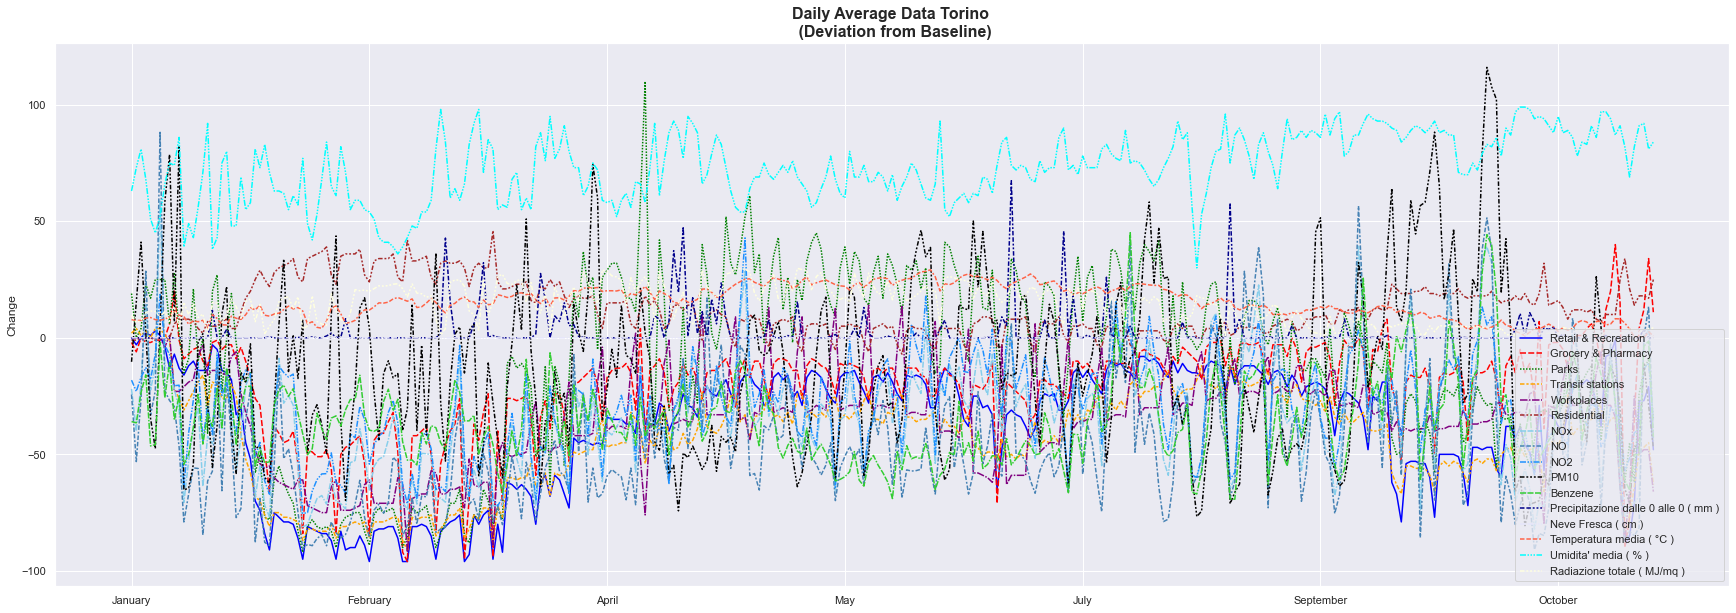

<Figure size 432x288 with 0 Axes>

In [33]:
palette = ["blue","red","green","orange","purple","brown","skyblue","steelblue", "dodgerblue","black", "limegreen",
 'darkblue', 'lavender','tomato', 'aqua', 'lightyellow',]
fig, ax = plt.subplots(figsize=(30, 10))
chart = sns.lineplot(data=merged_data, palette=palette)
plt.ylabel('Change')
plt.title("Daily Average Data Torino \n (Deviation from Baseline)",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
plt.legend(loc='lower right')
ax.xaxis.set_major_formatter(dates.DateFormatter("%B"))
plt.figure()



### Save CSV file

In [34]:
merged_data
# Remove all columns between column index 1 to 3
merged_data.drop(merged_data.iloc[:, 0:6], inplace = True, axis = 1)
#Unpivot a DataFrame from wide to long format
csv_data = merged_data.melt(id_vars="date", value_vars=['Retail & Recreation','Grocery & Pharmacy','Parks','Transit stations','Workplaces','Residential','NOx','NO','NO2','PM10','Benzene','Precipitazione dalle 0 alle 0 ( mm )','Neve Fresca ( cm )','Temperatura media ( °C )',"Umidita' media ( % )",'Radiazione totale ( MJ/mq )'],
      var_name='type', value_name='value', ignore_index=True)
#Save data to CSV file
csv_data.to_csv('data/Output/turin_daily_deviation.csv')
